In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.signal as sigs
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product

tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 4,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":5,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
        'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
        "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    
%config InlineBackend.close_figures=False # keep figures open in pyplot
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':"tight", 'pad_inches':2}

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4CM": "g", 
          "4EM": "m", 
          "4Naive":"#a4e0ef", 
          "Kihi":"#ff7f0e",
         "Kilo":"#02feff",
          "Kimid":"r",
         "Young":"#7d81fc",
         "Old":"#f50aff"}

my_marks = {"Donor": "o", 
           "Host": "X",
         "4CM":"o",
         "4EM":"P",
         "4Naive":"^"}

scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':"k",
}


def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #golden_ratio = (5**.5 - 1) / 2
    golden_ratio = 1

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

#loading dataframes for parameters and data
# df_para = pd.read_csv('/home/elise/Code/BRDU/parameters_est.csv')
# df = pd.read_csv('/home/elise/Code/BRDU/Elisehasbeenusing_dataUCL.csv',index_col='index')
# df['age_cat']=np.where(df.age < 114, 'wt', pd.np.where((df.age >= 114) & (df.age < 180), 'Young', 'Old'))

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

def myMAP(data):
    
#     counts, x = np.histogram(data,bins=(np.int(np.rint(np.sqrt(len(data))))))
#     x_ind = np.unravel_index(np.argmax(counts), counts.shape)
# #     arrayed = data.to_numpy()

# #     i_peaks, _ = sigs.find_peaks(arrayed)

# #     i_peaks
# #     arrayed[i_peaks]

# #     # Find the index from the maximum peak
# #     i_max_peak = i_peaks[np.argmax(_['widths'])]

# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]


# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]
#     return x[x_ind]

    arrayed = data.to_numpy()
    nparam_density = sts.kde.gaussian_kde(arrayed)
    x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
    nparam_density = nparam_density(x)

    return x[np.argsort(nparam_density)[-1]]

In [2]:
#splines all data >5
# run = "_r6"
# location = '/opt/mesh/tiree/elise/samples_1/cd4_skin'+run

#splines remove >5 and <400
# run = "_r7"
# location = '/opt/mesh/tiree/elise/samples_1/cd4_skin'+run

#simuluatenous remove >5
# run = "_r1"
# location = '/opt/mesh/tiree/elise/samples_1/cd4_all'+run

#simuluatenous remove >5 and <400
# run = "_r2"
# location = '/opt/mesh/tiree/elise/samples_1/cd4_all'+run

#simuluatenous remove >5 tighter sigma prior
run = "_r3"
location = '/opt/mesh/tiree/elise/samples_1/cd4_all'+run


In [3]:
typei = "homog"

precursorc = ['4Naive','4EM','4CM','69']
populationc = ['4EM','4EM.CD69+']
ki67c = ['Kihi','Kimid','Kilo']
organc=['SK','LP']

# dfoldyfp = dfyfp[(dfyfp['organ'] == 'SK')]
# dfoldtom = dftom[(dftom['organ'] == 'SK')]

parnames = ["alpha_A","delta_A","beta","Source","efft","effy"] 
pretty_parnames = ["$\\alpha$_A","$\\delta$_A","$\\beta$","Source","$\\epsilon$_t","$\\epsilon$_y"] #


pardf = pd.DataFrame()

for idx, adhpop in enumerated_product(precursorc,populationc,ki67c,organc):
    fullloc = location+"/stan-cache-"+adhpop[1]+adhpop[0]+adhpop[2]+adhpop[3]+"_"+str(1)+"/"
    
    print(idx)
    print(adhpop)
    
    fl = []
    fb = []
    fh = []
    
    #data slicing and manulipulation

    sys.path.insert(1, fullloc)
    import paras
    reload(paras)
    
    for f_name in os.listdir(fullloc):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(fullloc+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(fullloc+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('homog'):
            print(f_name)
            fh.append(fullloc+f_name)

    if typei == "branched":
        sam = cmdstanpy.from_csv(fb)
    else:
        sam = cmdstanpy.from_csv(fh)

        

    parests_flvl = [sam.stan_variable(pn) for pn in parnames]

    k_hat_fl =  sam.stan_variable("k_hat_y")
    kihi_fl =  sam.stan_variable("f_kihi_y_calc")
    
    if (adhpop[0]=='69')&(adhpop[1]=='4EM'):
        pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames)
        pardf_lvl['organ']=adhpop[3]
        pardf_lvl['population']=paras.populationc
        if adhpop[0]=='69':
            pardf_lvl['precursor']='CD'+paras.precursor+'-'
        else:
            pardf_lvl['precursor']=paras.precursor
        pardf_lvl['kisource']=adhpop[2]
        pardf_lvl['ones']=1
        pardf_lvl['alpha_adata']=1/paras.alpha_A
        pardf_lvl['delta_adata']=1/paras.delta_A
        pardf_lvl['betadata']=1/paras.beta
        pardf_lvl['efftdata']=paras.efft
        pardf_lvl['sourcedata']=paras.Source
        pardf_lvl['counts_t0']=paras.counts_t0_y
        pardf_lvl['TotalCount']=np.mean(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
        pardf_lvl['KihiFrac'] = np.mean(kihi_fl,axis=1)
        pardf_lvl["propprod"] = pardf_lvl["Source"]

        pardf = pd.concat([pardf,pardf_lvl])
    else:
        pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames)
        pardf_lvl['organ']=adhpop[3]
        pardf_lvl['population']=paras.populationc
        if adhpop[0]=='69':
            pardf_lvl['precursor']='CD'+paras.precursor+'-'
        else:
            pardf_lvl['precursor']=paras.precursor
        pardf_lvl['kisource']=adhpop[2]
        pardf_lvl['ones']=1
        pardf_lvl['alpha_adata']=1/paras.alpha_A
        pardf_lvl['delta_adata']=1/paras.delta_A
        pardf_lvl['betadata']=1/paras.beta
        pardf_lvl['efftdata']=paras.efft
        pardf_lvl['sourcedata']=paras.Source
        pardf_lvl['counts_t0']=paras.counts_t0_y
        pardf_lvl['TotalCount']=np.mean(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
        pardf_lvl['KihiFrac'] = np.mean(kihi_fl,axis=1)
        pardf_lvl["propprod"] = 100*pardf_lvl["alpha_A"]*pardf_lvl["counts_t0"]/(pardf_lvl["alpha_A"]*pardf_lvl["counts_t0"]  +  pardf_lvl["Source"])


        pardf = pd.concat([pardf,pardf_lvl])
    #     pardf = pd.concat([pardf,pardf_bvl])



pardf["inv_alpha_A"] = pardf["ones"].div(pardf["alpha_A"].values)
pardf["inv_delta_A"] = pardf["ones"].div(pardf["delta_A"].values)
pardf["inv_beta"] = pardf["ones"].div(pardf["beta"].values)
pardf["frac_source"] = 100*pardf["Source"].div(pardf["counts_t0"].values)
pardf["lambda_A"] = (pardf["delta_A"] - pardf["alpha_A"])
pardf["ln_lambda"] = np.log(2)/(pardf["lambda_A"])


(0, 0, 0, 0)
('4Naive', '4EM', 'Kihi', 'SK')
homog-20240917163709_3.csv
homog-20240917163709_1.csv
homog-20240917163709_2.csv
homog-20240917163709_4.csv
homog-20240917163709_5.csv
(0, 0, 0, 1)
('4Naive', '4EM', 'Kihi', 'LP')
homog-20240917163708_1.csv
homog-20240917163708_2.csv
homog-20240917163708_4.csv
homog-20240917163708_3.csv
homog-20240917163708_5.csv
(0, 0, 1, 0)
('4Naive', '4EM', 'Kimid', 'SK')
homog-20240917163740_2.csv
homog-20240917163740_5.csv
homog-20240917163740_1.csv
homog-20240917163740_4.csv
homog-20240917163740_3.csv
(0, 0, 1, 1)
('4Naive', '4EM', 'Kimid', 'LP')
homog-20240917163733_5.csv
homog-20240917163733_1.csv
homog-20240917163733_2.csv
homog-20240917163733_4.csv
homog-20240917163733_3.csv
(0, 0, 2, 0)
('4Naive', '4EM', 'Kilo', 'SK')
homog-20240917163716_2.csv
homog-20240917163716_1.csv
homog-20240917163716_4.csv
homog-20240917163716_3.csv
homog-20240917163716_5.csv
(0, 0, 2, 1)
('4Naive', '4EM', 'Kilo', 'LP')
homog-20240917163727_1.csv
homog-20240917163727_5.csv

(3, 1, 2, 0)
('69', '4EM.CD69+', 'Kilo', 'SK')
homog-20240917164334_4.csv
homog-20240917164334_3.csv
homog-20240917164334_1.csv
homog-20240917164334_2.csv
homog-20240917164334_5.csv
(3, 1, 2, 1)
('69', '4EM.CD69+', 'Kilo', 'LP')
homog-20240917164343_4.csv
homog-20240917164343_3.csv
homog-20240917164343_1.csv
homog-20240917164343_5.csv
homog-20240917164343_2.csv


In [4]:
from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'doh'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['age'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
#         print("Mann Whitney Ustat calculated p:",
#               pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
#     print("pvalues:", pvalues)
    
    return pvalues

In [9]:
organc = ['LP']


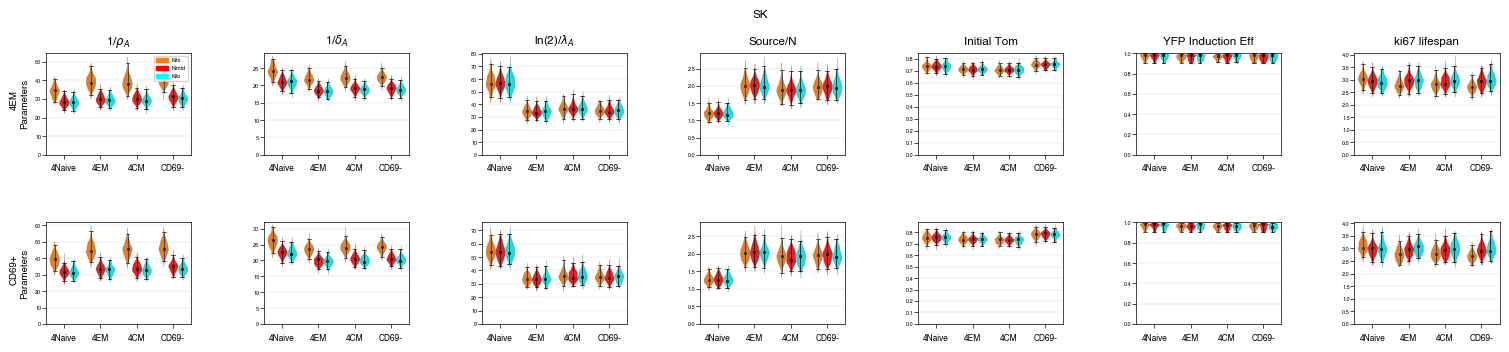

In [6]:


precursorc = ['4Naive','4EM','4CM','CD69-']
populationc = ['4EM','4EM.CD69+']
ki67c = ['Kihi','Kimid','Kilo']

ys = ["inv_alpha_A","inv_delta_A","ln_lambda","frac_source","efft","effy","inv_beta"]
nice_ys = ["1/$\\rho_A$","1/$\\delta_A$", "ln(2)/$\\lambda_A$","Source/N","Initial Tom","YFP Induction Eff","ki67 lifespan"]

fig = plt.figure(figsize=(15,3.5))
spec = fig.add_gridspec(nrows=3,ncols=1,height_ratios=[1,0.1,1])


for idx, adhpop in enumerated_product(organc,populationc):
    pop_i = adhpop[1]
    df = pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    pointplotkwags = {"data":pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"precursor",
                      "hue":"kisource",
                      "dodge":0.5, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"precursor",
                      "hue":"kisource",
                       "saturation":0.7, 
                       #"split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
  
    
    spec1 = spec[2*idx[1]].subgridspec(ncols=len(ys), nrows=1,hspace = 0, wspace=0.5)
    for idy, yss in enumerated_product(ys):
        y = yss[0]
        ax1 = fig.add_subplot(spec1[idx[0],idy[0]])
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags)

        ax1.set_ylabel('')
        ax1.set_xlabel('')
#         ax1.set_xticklabels('')
        ax1.legend([],[],frameon=False)
        ax1.set_ylim(bottom=0)
        
        if (idy[0]==0)&(idx[1]==0):
#             ax1.set_ylim(top=0.04)
            d = mpatches.Patch(color="#02feff", label='Kilo')
            h = mpatches.Patch(color="#ff7f0e", label='Kihi')
            m = mpatches.Patch(color="r", label='Kimid')
            ax1.legend(handles=[h,m,d],loc="upper right", fontsize="xx-small")
            ax1.set_ylabel('Parameters')
            ax1.set_title(nice_ys[idy[0]])

        elif idx[1]==0:
            ax1.set_title(nice_ys[idy[0]])
        elif idy[0]==0:
            ax1.set_ylabel('Parameters')
            


fig.text(0.0,0.7,'4EM',rotation='vertical')
fig.text(0.0,0.2,'CD69+',rotation='vertical')
fig.align_ylabels()


plt.suptitle(organc[0])
plt.tight_layout()

fig.savefig('/home/elise/Dropbox/elisepaperclone/CD4SkinGut/Figures/parameters'+organc[0]+'.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

fig.savefig('/home/elise/Dropbox/elisepaperclone/CD4SkinGut/Figures/parameters'+organc[0]+'.png', dpi='figure', format='png',
        bbox_inches='tight', pad_inches=0.1)



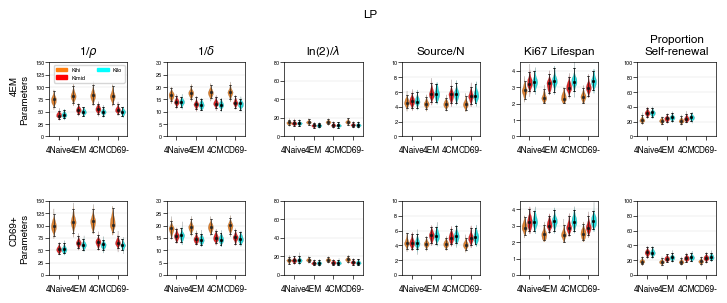

In [13]:

precursorc = ['4Naive','4EM','4CM','CD69-']
populationc = ['4EM','4EM.CD69+']
ki67c = ['Kihi','Kimid','Kilo']

ys = ["inv_alpha_A","inv_delta_A","ln_lambda","frac_source","inv_beta","propprod"]
nice_ys = ["1/$\\rho$","1/$\\delta$", "ln(2)/$\\lambda$","Source/N","Ki67 Lifespan","Proportion\nSelf-renewal"]


fig = plt.figure(figsize=(7.2,3))
spec = fig.add_gridspec(nrows=3,ncols=1,height_ratios=[1,0.1,1])


for idx, adhpop in enumerated_product(organc,populationc):
    pop_i = adhpop[1]
    df = pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    pointplotkwags = {"data":pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"precursor",
                      "hue":"kisource",
                      "dodge":0.5, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['organ'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"precursor",
                      "hue":"kisource",
                       "saturation":0.7, 
                       #"split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
  
    
    spec1 = spec[2*idx[1]].subgridspec(ncols=len(ys), nrows=1,hspace = 0, wspace=0.5)
    for idy, yss in enumerated_product(ys):
        y = yss[0]
        ax1 = fig.add_subplot(spec1[idx[0],idy[0]])
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags)

        ax1.set_ylabel('')
        ax1.set_xlabel('')
#         ax1.set_xticklabels('')
        ax1.legend([],[],frameon=False)
        ax1.set_ylim(bottom=0)
        
        if True:  #(organc[0]=='SK':
            if (idy[0]==0)&(idx[1]==0):
    #             ax1.set_ylim(top=0.04)
                d = mpatches.Patch(color="#02feff", label='Kilo')
                h = mpatches.Patch(color="#ff7f0e", label='Kihi')
                m = mpatches.Patch(color="r", label='Kimid')
                ax1.legend(handles=[h,m,d],loc="upper right", fontsize="xx-small",ncol=2)
                ax1.set_ylabel('Parameters')
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim(top=150)
            elif (idx[1]==0)&(idy[0]==5):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,100]) 
            elif (idx[1]==0)&(idy[0]==4):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim(top=4.5) 
            elif (idx[1]==0)&(idy[0]==3):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim(top=10) 
            elif (idx[1]==0)&(idy[0]==2):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,80])
            elif (idx[1]==0)&(idy[0]==1):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim(top=30) 
            elif idx[1]==0:
                ax1.set_title(nice_ys[idy[0]])
            elif idy[0]==0:
                ax1.set_ylabel('Parameters')
                ax1.set_ylim(top=150)
            elif (idy[0]==1):
                ax1.set_ylim([0,30])
            elif (idy[0]==2):
                ax1.set_ylim(top=80)
            elif (idy[0]==3):
                ax1.set_ylim(top=10) 
            elif (idy[0]==4):
                ax1.set_ylim(top=4.5) 
            elif (idy[0]==5):
                ax1.set_ylim(top=100)
        else:
            if (idy[0]==0)&(idx[1]==0):
    #             ax1.set_ylim(top=0.04)
                d = mpatches.Patch(color="#02feff", label='Kilo')
                h = mpatches.Patch(color="#ff7f0e", label='Kihi')
                m = mpatches.Patch(color="r", label='Kimid')
                ax1.legend(handles=[h,m,d],loc="upper right", fontsize="xx-small",ncol=2)
                ax1.set_ylabel('Parameters')
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,150])
#                 ax1.set_yscale('log')
            
            elif (idx[1]==0)&(idy[0]==4):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,4.5]) 
            elif (idx[1]==0)&(idy[0]==3):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,8])   
            elif (idx[1]==0)&(idy[0]==2):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,25]) 
            elif (idx[1]==0)&(idy[0]==1):
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,25]) 
            elif idx[1]==0:
                ax1.set_title(nice_ys[idy[0]])
            elif idy[0]==0:
                ax1.set_ylabel('Parameters')
                ax1.set_title(nice_ys[idy[0]])
                ax1.set_ylim([0,150])
#                 ax1.set_yscale('log')
            elif (idy[0]==1):
                ax1.set_ylim([0,25])
            elif (idy[0]==3):
                ax1.set_ylim([0,8]) 
            elif (idy[0]==4):
                ax1.set_ylim([0,4.5])
            elif (idy[0]==5):
                ax1.set_ylim([0,100]) 


fig.text(0.0,0.7,'4EM',rotation='vertical')
fig.text(0.0,0.2,'CD69+',rotation='vertical')
fig.align_ylabels()


plt.suptitle(organc[0])
plt.tight_layout()

fig.savefig('/home/elise/Dropbox/elisepaperclone/CD4SkinGut/Figures/int_parameters'+organc[0]+'.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

fig.savefig('/home/elise/Dropbox/elisepaperclone/CD4SkinGut/Figures/int_parameters'+organc[0]+'.png', dpi='figure', format='png',
        bbox_inches='tight', pad_inches=0.1)

